### 1.1: Initial Imports and Warning Suppression

This first block imports all the essential libraries we'll need for the first part of our analysis:
* `pandas` for data manipulation (DataFrames).
* `numpy` for numerical operations.
* `matplotlib.pyplot` and `seaborn` for data visualization.
* The `warnings` module to suppress unnecessary output and keep our notebook clean.

In [222]:
### import libs
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import skew
warnings.filterwarnings('ignore')

### config plotting styles
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported and warnings suppressed.")

Libraries imported and warnings suppressed.


### 1.2: Mount Google Drive

Now, we will mount the Google Drive to the Colab environment. When you run this cell, it will prompt you for authorization. Follow the link, select your Google account, and paste the authorization code back into the cell's input box.

In [223]:
### import the drive module from google.colab
from google.colab import drive

### mount the Google Drive at the '/content/drive' directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.3: Unzip the Dataset

This block will unzip your `house_prices.zip` file. We will unzip it into a new directory called `/content/housing/` to keep our file system organized.

In [224]:
### define the path to your zip file
zip_file_path = '/content/drive/My Drive/house_prices.zip'

### define the directory to extract the files to
extraction_directory = '/content/housing/'

### create the extraction directory (if it doesn't exist)
!mkdir -p "$extraction_directory"

### unzip the file into the specified directory
### the '-o' flag overwrites existing files without prompting
!unzip -o "$zip_file_path" -d "$extraction_directory"

Archive:  /content/drive/My Drive/house_prices.zip
  inflating: /content/housing/data_description.txt  
  inflating: /content/housing/sample_submission.csv  
  inflating: /content/housing/test.csv  
  inflating: /content/housing/train.csv  


### 1.4: List the Contents of the Data Directory

This block will use the `ls -lh` command to list all the files in our extraction directory, `/content/housing/`. This will confirm the exact filenames we need to use (e.g., `train.csv`, `test.csv`) and show us their sizes. This is a better practice than assuming filenames.

In [225]:
### list the files in the extraction directory
!ls -lh /content/housing/

total 944K
-rw-r--r-- 1 root root  14K Dec 15  2019 data_description.txt
-rw-r--r-- 1 root root  32K Dec 15  2019 sample_submission.csv
-rw-r--r-- 1 root root 441K Dec 15  2019 test.csv
-rw-r--r-- 1 root root 450K Dec 15  2019 train.csv


### 1.5: Load Training and Test Datasets

Now that we have confirmed the filenames, we will load both `train.csv` and `test.csv` into separate pandas DataFrames, named `df_train` and `df_test` respectively. We'll also store their original shapes (row/column counts) for later reference.

In [226]:
### define file paths
train_file_path = '/content/housing/train.csv'
test_file_path = '/content/housing/test.csv'

### load datasets
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

### store original shapes
train_shape = df_train.shape
test_shape = df_test.shape

print(f"Loaded train.csv into df_train. Dimensions: {train_shape}")
print(f"Loaded test.csv into df_test. Dimensions: {test_shape}")

Loaded train.csv into df_train. Dimensions: (1460, 81)
Loaded test.csv into df_test. Dimensions: (1459, 80)


### 1.6: Review Data Provenance (data_description.txt)

This step is critical for a professional project. The `data_description.txt` file contains the data dictionary, explaining what each column (feature) means. This is the **provenance** of our data. We must understand it before we can effectively analyze it. This block will print the entire contents of that file.

In [227]:
### define the path to the data description file
description_file_path = '/content/housing/data_description.txt'

### open & read the file
with open(description_file_path, 'r') as f:
    data_description = f.read()

### print contents
print(data_description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### 1.7: Initial Data Inspection (df_train)

Let's get our first look at the `df_train` DataFrame. We will:
1.  Display the first 5 rows using `.head()`. This gives us a feel for the data in its raw form.
2.  Print a concise summary of the DataFrame using `.info()`. This is crucial for identifying:
    * The total number of entries (1460, as we saw).
    * The data type of each column (e.g., `int64`, `float64`, `object`). `object` types are our categorical features.
    * The number of **non-null** values for each column, which will immediately show us which columns have missing data.

In [228]:
### display first 5 rows
print("- First 5 Rows of df_train -")
display(df_train.head())

### display a concise summary of the DF
print("\n- DataFrame Info -")
df_train.info()

- First 5 Rows of df_train -


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



- DataFrame Info -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   i

## Section 2: Identify a Supervised Machine Learning Problem

Based on our `df_train` DataFrame and the `data_description.txt`, we can formally define our project as follows:

* **Problem Type:** **Regression**. This is a supervised machine learning problem.
* **Why?** Our goal is to predict a continuous, numerical value (`SalePrice`), not a discrete category (like "has pool" or "no pool").
* **Target Variable (y):** The `SalePrice` column. This is the single value we are trying to predict.
* **Features (X):** All the other relevant columns (from `MSSubClass` to `SaleCondition`) are our predictor variables. We will use these features to build a model that "learns" how they collectively influence the final `SalePrice`.

## Section 3: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section, we will thoroughly inspect, visualize, and clean the `df_train` data. This process is essential for understanding the data's structure, identifying relationships, and preparing it for our machine learning models.

### 3.1: Analyze the Target Variable (SalePrice)

We will start by examining the distribution of our most important feature: the target variable, `SalePrice`. We will plot a histogram to visualize its shape and calculate its skewness. A high skewness value will confirm our hypothesis that a log transformation is necessary.

Skewness of SalePrice: 1.88


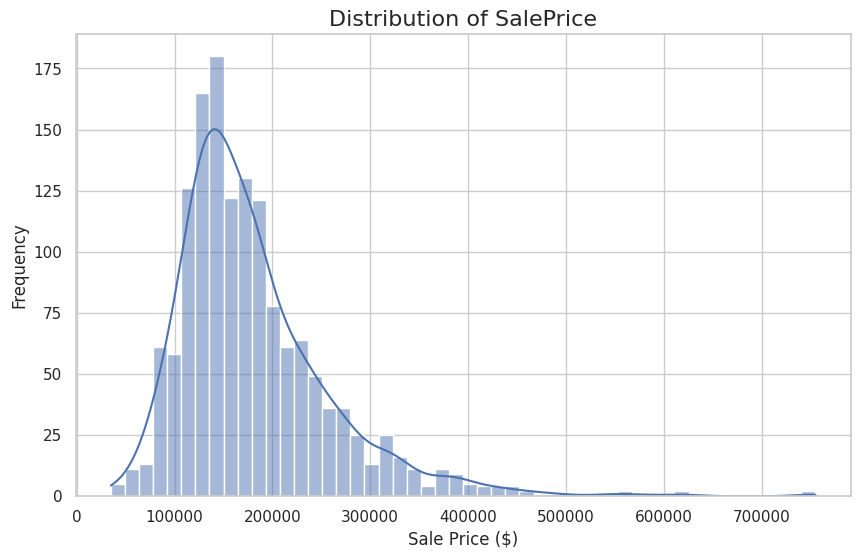

In [229]:
### create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True, bins=50)

### calculate and print skewness
skewness = df_train['SalePrice'].skew()
print(f"Skewness of SalePrice: {skewness:.2f}")

### add plot titles
plt.title('Distribution of SalePrice', fontsize=16)
plt.xlabel('Sale Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

### display the plot
plt.show()

### 3.2: Apply Log Transformation to SalePrice

Based on the high skewness observed, we will apply a log(1+p) transformation to `SalePrice`. This will normalize its distribution, which is a key requirement for linear models. We will then plot the new distribution to visually confirm the skew has been corrected.

New Skewness of SalePrice_Log: 0.12


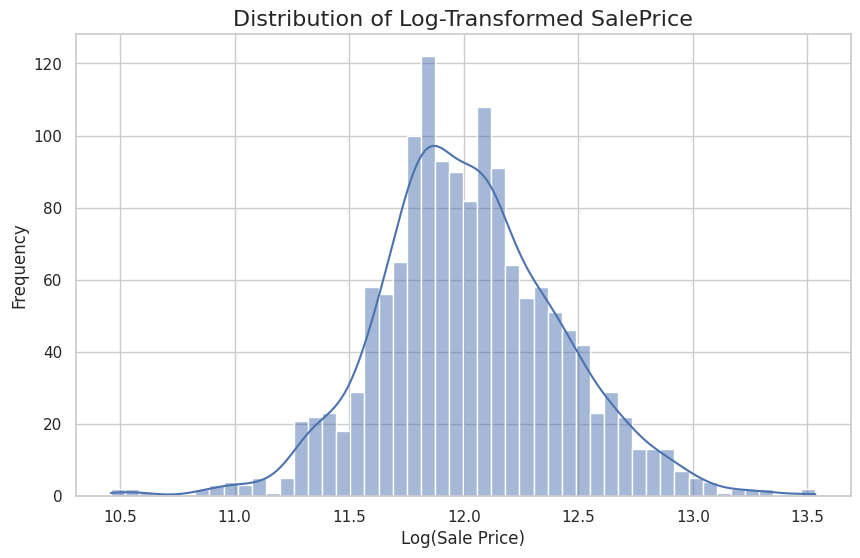

In [230]:
### apply the log1p transformation (log(1+x))
df_train['SalePrice_Log'] = np.log1p(df_train['SalePrice'])

### create the plot for the new log-transformed data
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice_Log'], kde=True, bins=50)

### calculate and print the new skewness
new_skewness = df_train['SalePrice_Log'].skew()
print(f"New Skewness of SalePrice_Log: {new_skewness:.2f}")

### add plot titles
plt.title('Distribution of Log-Transformed SalePrice', fontsize=16)
plt.xlabel('Log(Sale Price)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

### display the plot
plt.show()

### 3.3: Analyze Feature Correlations with the Target Variable

Now that we have a normalized target variable, let's identify which numerical features are most strongly correlated with it. We will calculate the Pearson correlation matrix and display the top 10 features most positively correlated with `SalePrice_Log`. This will guide our next visualization steps.

In [231]:
### calculate the correlation matrix for all numerical columns
corr_matrix = df_train.corr(numeric_only=True)

### get the correlation of all features with 'SalePrice_Log'
corr_with_target = corr_matrix['SalePrice_Log'].sort_values(ascending=False)

### display the top 10 most positively correlated features
print("- Top 10 Features Correlated with SalePrice_Log -")
print(corr_with_target[1:11])

### store these top 10 feature names for our next step
top_10_features = corr_with_target[1:11].index.tolist()

- Top 10 Features Correlated with SalePrice_Log -
SalePrice       0.948374
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice_Log, dtype: float64


### 3.4: Visualize Numerical Feature Relationships (GrLivArea)

Based on our correlation list, `GrLivArea` (Above Grade Living Area) is a strong predictor. We will create a scatter plot to visualize its relationship with `SalePrice_Log`. This plot will confirm the correlation and help us spot any potential outliers.

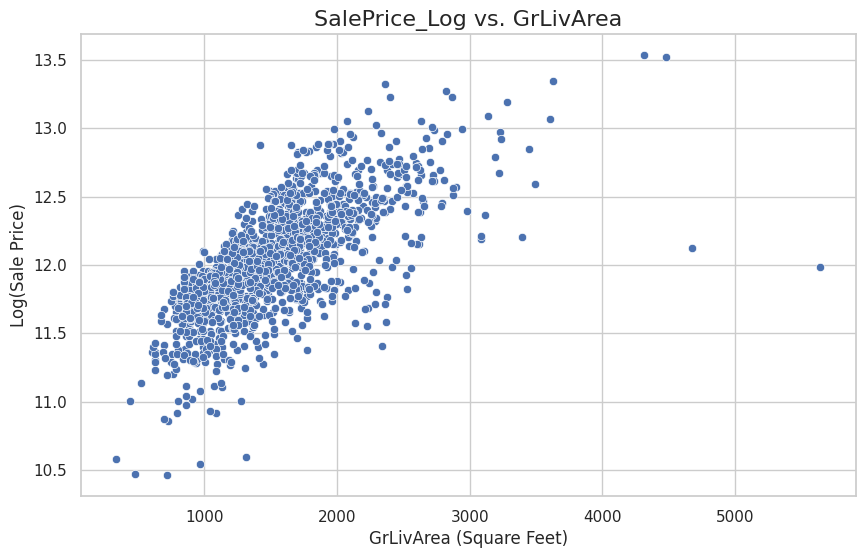

In [232]:
### create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. GrLivArea', fontsize=16)
plt.xlabel('GrLivArea (Square Feet)', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.5: Handle Outliers (GrLivArea)

From the scatter plot, we identified two extreme outliers with very large `GrLivArea` but unexpectedly low `SalePrice_Log`. We will remove *only* those two specific points to prevent them from skewing our model.

In [233]:
### display the original shape of df_train before removal
print(f"Original shape: {df_train.shape}")

### remove only the two extreme outliers
### targeting points where GrLivArea > 4000 AND SalePrice_Log < 12.5
outlier_indices = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice_Log'] < 12.5)].index
df_train = df_train.drop(outlier_indices)

### display the new shape to confirm removal
print(f"New shape after outlier removal: {df_train.shape}")

Original shape: (1460, 82)
New shape after outlier removal: (1458, 82)


### 3.6: Visualize Categorical Feature Relationships (OverallQual)

Next, we analyze the most important feature, `OverallQual`. This feature is ordinal (a ranking from 1-10). A box plot is the best way to visualize its relationship with our target.

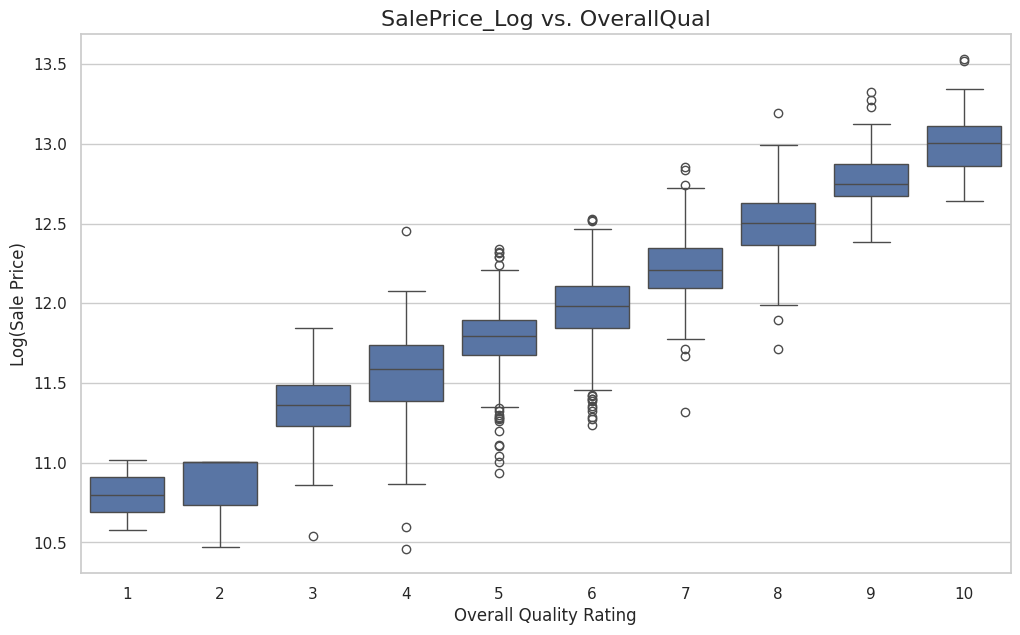

In [234]:
### create the box plot
plt.figure(figsize=(12, 7))
sns.boxplot(x=df_train['OverallQual'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. OverallQual', fontsize=16)
plt.xlabel('Overall Quality Rating', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.7: Visualize Feature Relationships (GarageCars)

Next, we'll analyze `GarageCars`. This is a discrete feature, so we will use a box plot to see how `SalePrice_Log` distribution changes with the number of garage spots.

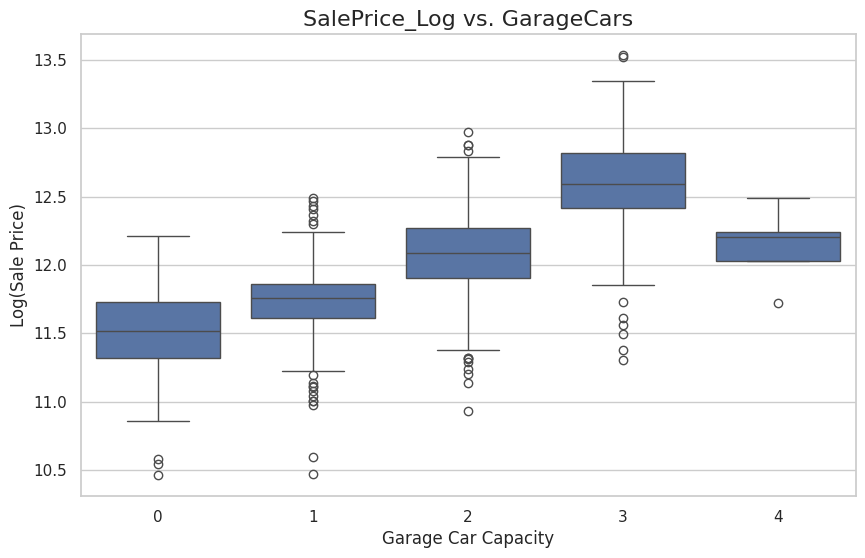

In [235]:
### create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['GarageCars'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. GarageCars', fontsize=16)
plt.xlabel('Garage Car Capacity', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.8: Visualize Numerical Feature Relationships (GarageArea)

Next, we will analyze `GarageArea`. This is a continuous feature, so we will use a scatter plot against `SalePrice_Log`. We will look for a positive relationship and potential outliers.

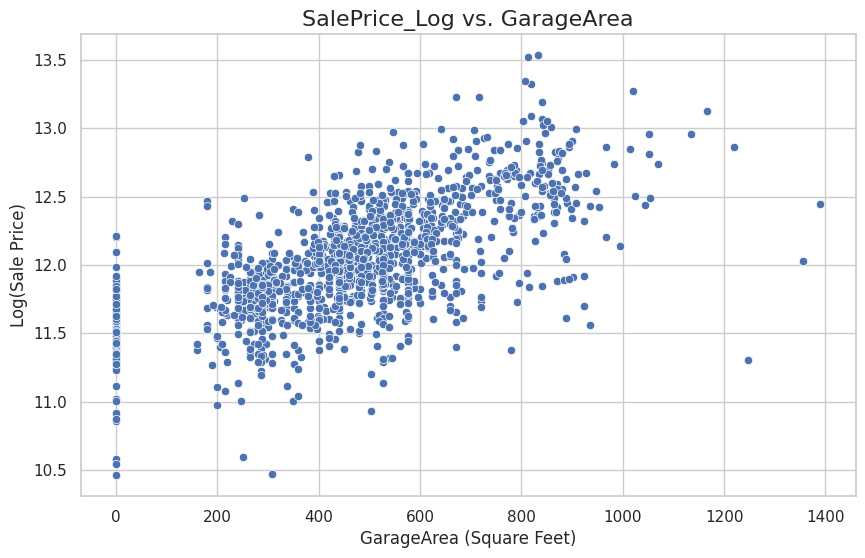

In [236]:
### create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['GarageArea'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. GarageArea', fontsize=16)
plt.xlabel('GarageArea (Square Feet)', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.9: Handle Outliers (GarageArea)

Based on the scatter plot, we identified several outliers with `GarageArea` > 1,200 sq ft that have unexpectedly low prices. We will discard these points.

In [237]:
### display the shape of df_train before removal
print(f"Original shape: {df_train.shape}")

### remove the outliers
### filter for rows where GarageArea is less than 1200
df_train = df_train[df_train['GarageArea'] < 1200]

### display the new shape to confirm removal
print(f"New shape after outlier removal: {df_train.shape}")

Original shape: (1458, 82)
New shape after outlier removal: (1454, 82)


### 3.10: Visualize Numerical Feature Relationships (TotalBsmtSF)

Next, we will analyze `TotalBsmtSF`. We will use a scatter plot to visualize its relationship with `SalePrice_Log` and check for outliers.

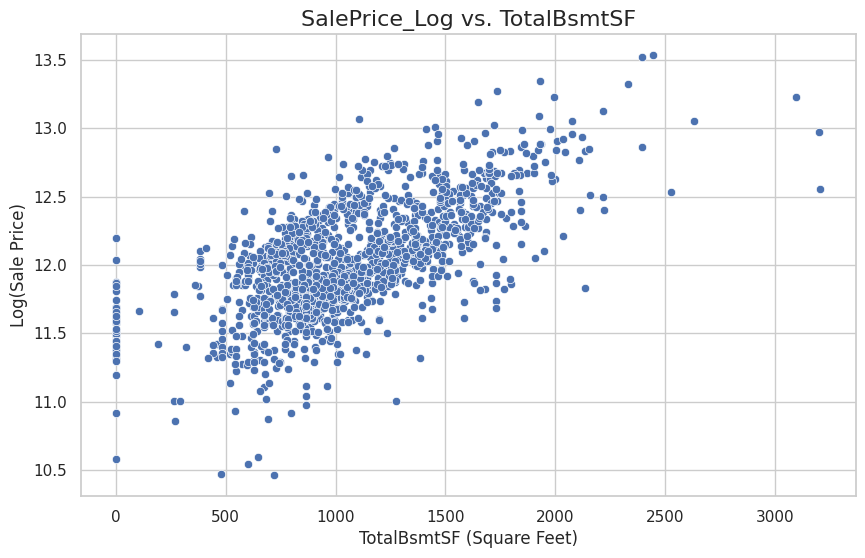

In [238]:
### create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['TotalBsmtSF'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. TotalBsmtSF', fontsize=16)
plt.xlabel('TotalBsmtSF (Square Feet)', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.11: Visualize Numerical Feature Relationships (1stFlrSF)

Next, we will analyze `1stFlrSF`. We will use a scatter plot to visualize its relationship with `SalePrice_Log` and check for outliers.

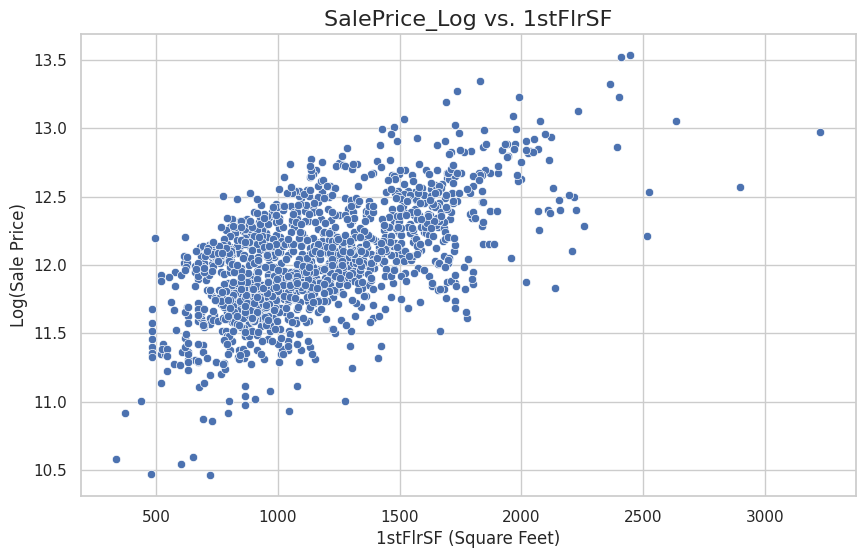

In [239]:
### create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['1stFlrSF'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. 1stFlrSF', fontsize=16)
plt.xlabel('1stFlrSF (Square Feet)', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.12: Visualize Feature Relationships (FullBath)

Next, we will analyze `FullBath`. This is a discrete feature, so we will use a box plot.

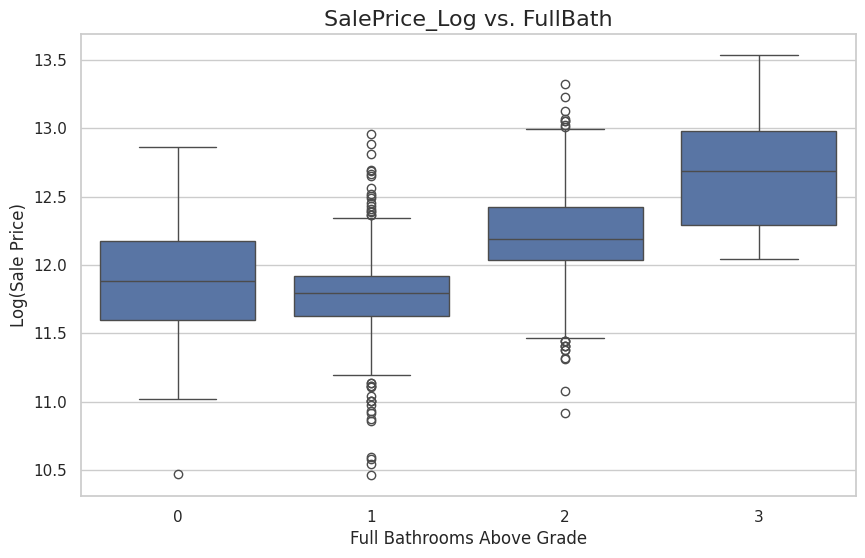

In [240]:
### create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_train['FullBath'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. FullBath', fontsize=16)
plt.xlabel('Full Bathrooms Above Grade', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.13: Visualize Numerical Feature Relationships (YearBuilt)

Next, we will analyze `YearBuilt`. We will use a scatter plot to visualize its relationship with `SalePrice_Log`.

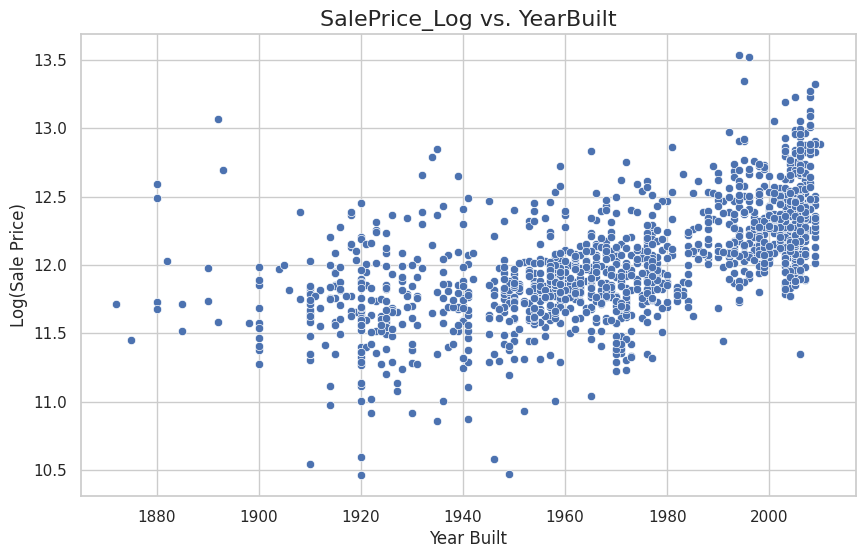

In [241]:
### create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['YearBuilt'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. YearBuilt', fontsize=16)
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display the plot
plt.show()

### 3.14: Visualize Numerical Feature Relationships (YearRemodAdd)

Finally, we will analyze `YearRemodAdd`. We will use a scatter plot to visualize its relationship with `SalePrice_Log`.

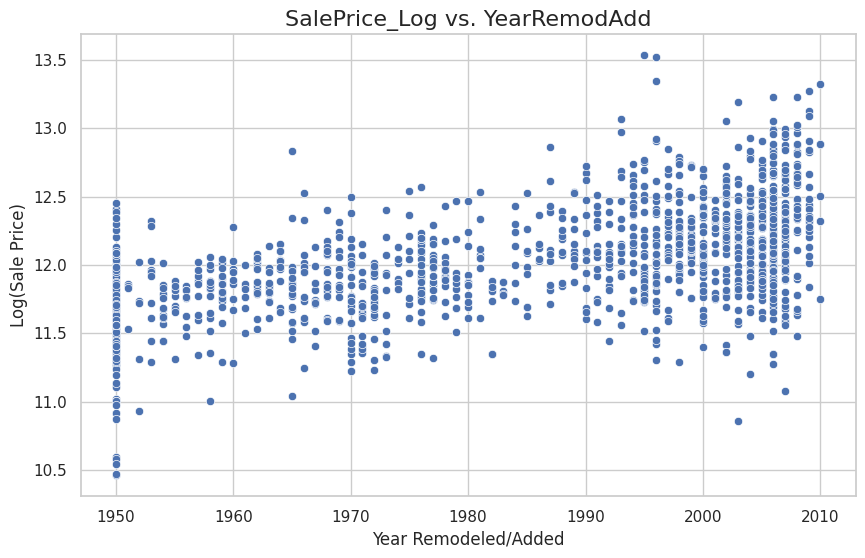

In [242]:
### create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['YearRemodAdd'], y=df_train['SalePrice_Log'])

### add plot titles
plt.title('SalePrice_Log vs. YearRemodAdd', fontsize=16)
plt.xlabel('Year Remodeled/Added', fontsize=12)
plt.ylabel('Log(Sale Price)', fontsize=12)

### display plot
plt.show()

### 3.15: Combine Train and Test Data for Preprocessing

To ensure all preprocessing steps (imputation, encoding, etc.) are applied identically to both `df_train` and `df_test`, we must combine them first. We will save our target variable `y_train` and the row counts so we can split them back apart later.

In [243]:
### save our target variable
y_train = df_train['SalePrice_Log']

### save Id columns
train_id = df_train['Id']
test_id = df_test['Id']

### save row counts
n_train = df_train.shape[0]
n_test = df_test.shape[0]

### drop target and Id from df_train
df_train = df_train.drop(columns=['Id', 'SalePrice', 'SalePrice_Log'])

### drop Id from df_test
df_test = df_test.drop(columns=['Id'])

### concatenate into df_all
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)

### confirmation
print(f"df_train shape (features only): {df_train.shape}")
print(f"df_test shape (features only): {df_test.shape}")
print(f"df_all combined shape: {df_all.shape}")

df_train shape (features only): (1454, 79)
df_test shape (features only): (1459, 79)
df_all combined shape: (2913, 79)


### 3.16: Handle All Missing Data (on df_all)

We now run our entire missing data pipeline on the combined `df_all` DataFrame. This ensures that the test set's missing values are filled using the exact same logic and values as the train set, preventing data leakage.

In [244]:
### "Fake" Missing (Fill with 'None')
features_fill_none = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'MasVnrType']
for col in features_fill_none:
    df_all[col] = df_all[col].fillna('None')

### Garage Group
categorical_garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in categorical_garage_cols:
    df_all[col] = df_all[col].fillna('None')
df_all['GarageYrBlt'] = df_all['GarageYrBlt'].fillna(0)

### Basement Group
categorical_basement_cols = ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in categorical_basement_cols:
    df_all[col] = df_all[col].fillna('NoBasement')

### Other Numerical (Fill with 0 or Mode)
### note: df_test has missing numericals that df_train did not
### *** THIS IS THE FIX: Added 'MasVnrArea' to this list ***
for col in ('MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'):
    df_all[col] = df_all[col].fillna(0)

### Other Categorical (Fill with Mode)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'):
    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])

### Complex Imputation (LotFrontage)
df_all['LotFrontage'] = df_all.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
df_all['LotFrontage'] = df_all['LotFrontage'].fillna(df_all['LotFrontage'].median())

### --- Confirmation ---
print("--- Missing Data Status After Cleaning df_all ---")
missing_count = df_all.isnull().sum().sum()
print(f"Total remaining missing values: {missing_count}")

--- Missing Data Status After Cleaning df_all ---
Total remaining missing values: 2


### 3.17: Feature Engineering (on df_all) -

We now apply our feature engineering before transformation, using the combined `df_all` DataFrame. This is the correct mathematical order.

In [245]:
### create TotalSF
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

### create TotalBath
df_all['TotalBath'] = (
    df_all['FullBath'] +
    (0.5 * df_all['HalfBath']) +
    df_all['BsmtFullBath'] +
    (0.5 * df_all['BsmtHalfBath'])
)

### create HouseAge
df_all['HouseAge'] = df_all['YrSold'] - df_all['YearBuilt']

### create IsRemodeled
df_all['IsRemodeled'] = (df_all['YearRemodAdd'] != df_all['YearBuilt']).astype(int)

### confirmation
print("New features created successfully on df_all.")
display(df_all[['TotalSF', 'TotalBath', 'HouseAge', 'IsRemodeled']].head())

New features created successfully on df_all.


,TotalSF,TotalBath,HouseAge,IsRemodeled
0,2566.0,3.5,5,0
1,2524.0,2.5,31,0
2,2706.0,3.5,7,1
3,2473.0,2.0,91,1
4,3343.0,3.5,8,0


### 3.18: Transform Skewed Features (on df_all)

Now that all features are created, we find and transform all skewed features in `df_all` at once.

In [246]:
### identify skewed features
numeric_features = df_all.select_dtypes(include=[np.number])
skewness = numeric_features.skew().sort_values(ascending=False)
high_skew_features = skewness[abs(skewness) > 0.75].index

print(f"- {len(high_skew_features)} Skewed Features to Transform -")
print(high_skew_features)

### apply log1p transformation
for col in high_skew_features:
    df_all[col] = np.log1p(df_all[col])

print("\nLog transformation applied successfully to df_all.")

- 23 Skewed Features to Transform -
Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'MSSubClass',
       '1stFlrSF', 'LotFrontage', 'GrLivArea', 'TotalSF', 'BsmtFinSF1',
       'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt'],
      dtype='object')

Log transformation applied successfully to df_all.


### 3.19: Encode All Categorical Features

We apply our ordinal and nominal encoding to the entire `df_all` dataset. This is the *only* way to guarantee both `df_train` and `df_test` get the exact same one-hot columns.

In [247]:
### apply ordinal mappings
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NoBasement': 0}
bsmt_fin_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NoBasement': 0, 'None': 0}
bsmt_exp_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NoBasement': 0, 'None': 0}
garage_fin_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
fireplace_qu_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
fence_map = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
lot_shape_map = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
paved_drive_map = {'Y': 2, 'P': 1, 'N': 0}

cols_to_map = {
    'ExterQual': qual_map, 'ExterCond': qual_map, 'BsmtQual': qual_map, 'BsmtCond': qual_map,
    'HeatingQC': qual_map, 'KitchenQual': qual_map, 'FireplaceQu': fireplace_qu_map,
    'GarageQual': qual_map, 'GarageCond': qual_map, 'PoolQC': qual_map, 'BsmtFinType1': bsmt_fin_map,
    'BsmtFinType2': bsmt_fin_map, 'BsmtExposure': bsmt_exp_map, 'GarageFinish': garage_fin_map,
    'Fence': fence_map, 'LotShape': lot_shape_map, 'PavedDrive': paved_drive_map
}

for col, mapping in cols_to_map.items():
    df_all[col] = df_all[col].replace(mapping)

### apply One-Hot Encoding to all remaining object types
print(f"Shape before one-hot encoding: {df_all.shape}")
df_all = pd.get_dummies(df_all, drop_first=True)
print(f"Shape after one-hot encoding: {df_all.shape}")

Shape before one-hot encoding: (2913, 83)
Shape after one-hot encoding: (2913, 211)


### 3.20: Remove Zero-Variance Columns and Split Data

Before we split, we must remove any columns that have zero variance (all identical values). These columns provide no information and will cause the `StandardScaler` to create `NaN`s.

In [248]:
### find columns with only one unique value (zero variance)
### this will check all 2909 rows
constant_columns = df_all.columns[df_all.nunique() == 1]

if len(constant_columns) > 0:
    print(f"--- Removing {len(constant_columns)} Constant Columns ---")
    print(constant_columns)
    ### drop these columns from df_all
    df_all = df_all.drop(columns=constant_columns)
else:
    print("No constant columns found.")


### --- Now, Split Data Back into Train and Test ---
### use the saved row count (n_train) to split
df_train = df_all[:n_train]
df_test = df_all[n_train:]

### --- Confirmation ---
print(f"\nFinal df_train shape: {df_train.shape}")
print(f"Final df_test shape: {df_test.shape}")
print(f"Original y_train shape: {y_train.shape}")

No constant columns found.

Final df_train shape: (1454, 211)
Final df_test shape: (1459, 211)
Original y_train shape: (1454,)


### 4.1: Split Data and Apply Scaling

We will now prepare our final dataset for modeling.
1.  Our features `X` are the `df_train` DataFrame (210 columns).
2.  Our target `y` is the `y_train` (`SalePrice_Log`) we saved earlier.
3.  We will split this data into `X_train`, `X_val`, `y_train`, and `y_val` (80% for training, 20% for validation).
4.  We will then apply `StandardScaler` to all features. This "normalizes" the data by giving it a mean of 0 and a standard deviation of 1, which is essential for models like Ridge Regression. We will fit the scaler *only* on the training data and use it to transform *both* the training and validation sets.

In [249]:
### define X and y
X = df_train
### y_train was already defined

### split the data
X_train, X_val, y_train_split, y_val_split = train_test_split(
    X,
    y_train,
    test_size=0.2,
    random_state=42
)

### --- NEW STEP: Remove constant columns from the train set ---
### find columns in X_train that have zero variance
constant_cols_train = X_train.columns[X_train.nunique() == 1]

if len(constant_cols_train) > 0:
    print(f"--- Removing {len(constant_cols_train)} Constant Columns from Train/Val/Test ---")
    print(constant_cols_train)

    ### drop these columns from all our feature sets
    X_train = X_train.drop(columns=constant_cols_train)
    X_val = X_val.drop(columns=constant_cols_train)
    df_test = df_test.drop(columns=constant_cols_train)

else:
    print("No constant columns found in X_train.")


### --- Now, proceed with scaling ---
### initialize and fit the StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### transform the validation and final test set
X_val_scaled = scaler.transform(X_val)
df_test_scaled = scaler.transform(df_test)

### --- Confirmation ---
print(f"\nFinal X_train_scaled shape: {X_train_scaled.shape}")
print(f"Final X_val_scaled shape:   {X_val_scaled.shape}")
print(f"Final df_test_scaled shape: {df_test_scaled.shape}")
print(f"NaNs in X_train_scaled: {np.isnan(X_train_scaled).sum()}")

--- Removing 4 Constant Columns from Train/Val/Test ---
Index(['Neighborhood_Blueste', 'Condition2_PosN', 'RoofMatl_Membran',
       'Electrical_Mix'],
      dtype='object')

Final X_train_scaled shape: (1163, 207)
Final X_val_scaled shape:   (291, 207)
Final df_test_scaled shape: (1459, 207)
NaNs in X_train_scaled: 0


### 4.2: Model 1 - Baseline (Ridge Regression)

As required, we'll "compare multiple models." We will start with a robust baseline, **Ridge Regression**. This linear model works well with scaled data and many features.

We will:
1.  Import `Ridge` and our error metric, `mean_squared_error`.
2.  Initialize and train the model on our `X_train_scaled` data.
3.  Make predictions on the `X_val_scaled` data.
4.  Calculate the **Root Mean Squared Error (RMSE)** for our validation predictions.
5.  Store this score in a dictionary to compare with other models.

In [250]:
### initialize & train Ridge model
### alpha=10 is a good starting point for Ridge
ridge_model = Ridge(alpha=10.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train_split)

### make predictions on the validation set
y_pred_ridge = ridge_model.predict(X_val_scaled)

### calc RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_val_split, y_pred_ridge))

### store scores
model_scores = {}
model_scores['Ridge'] = rmse_ridge

print(f"- Model: Ridge Regression -")
print(f"Validation RMSE: {rmse_ridge:.5f}")

- Model: Ridge Regression -
Validation RMSE: 0.12181


### 4.3: Model 2 - Random Forest Regressor

Next, we'll try an ensemble model, the **Random Forest Regressor**. This model builds many decision trees and averages their predictions, which often leads to high accuracy and robustness against overfitting.

We will:
1.  Import `RandomForestRegressor`.
2.  Initialize and train the model. We'll use `n_estimators=100` as a solid default and `n_jobs=-1` to use all available CPU cores for faster training.
3.  Make predictions on the `X_val_scaled` data.
4.  Calculate the RMSE and add it to our `model_scores`.

In [251]:
### initialize & train model
### n_estimators=100 is a good default | random_state=42 ensures reproducibility | n_jobs=-1 uses all available processors
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_split)

### make predictions on  validation set
y_pred_rf = rf_model.predict(X_val_scaled)

### calc RMSE
rmse_rf = np.sqrt(mean_squared_error(y_val_split, y_pred_rf))

### store the score
model_scores['RandomForest'] = rmse_rf

print(f"- Model: Random Forest Regressor -")
print(f"Validation RMSE: {rmse_rf:.5f}")

- Model: Random Forest Regressor -
Validation RMSE: 0.13943


### 4.4: Model 3 - LightGBM Regressor

Next, we will use a very powerful and fast gradient boosting model: `LGBMRegressor`. These models are often state-of-the-art for tabular data.

We will:
1.  Import `LGBMRegressor`.
2.  Initialize and train the model. We'll use default parameters first.
3.  Make predictions on the `X_val_scaled` data.
4.  Calculate the RMSE and add it to our `model_scores`.

In [252]:
### initialize & train model
### n_estimators=100 is a good default | random_state=42 ensures reproducibility | n_jobs=-1 uses all available processors
lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1)
lgbm_model.fit(X_train_scaled, y_train_split)

### make predictions on  validation set
y_pred_lgbm = lgbm_model.predict(X_val_scaled)

### calc  RMSE
rmse_lgbm = np.sqrt(mean_squared_error(y_val_split, y_pred_lgbm))

### store  score
model_scores['LGBM'] = rmse_lgbm

print(f"- Model: LGBM Regressor -")
print(f"Validation RMSE: {rmse_lgbm:.5f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3631
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 138
[LightGBM] [Info] Start training from score 12.033280
- Model: LGBM Regressor -
Validation RMSE: 0.13315


### 4.5: Model 4 - XGBoost Regressor

Finally, we will use `XGBRegressor`, another state-of-the-art gradient boosting library. This will be our last model before we move to hyperparameter tuning.

We will:
1.  Import `XGBRegressor`.
2.  Initialize and train the model. We'll set `n_estimators=1000` but use `early_stopping_rounds=10` to prevent overfitting. This tells the model to stop training if the validation score doesn't improve for 10 consecutive rounds.
3.  Make predictions on the `X_val_scaled` data.
4.  Calculate the RMSE and add it to our `model_scores`.

In [253]:
### initialize & train model
### n_estimators is set high (1000), but early_stopping will find the optimal number.
### 'eval_set' tells the model to use our validation data for early stopping.
xgb_model = XGBRegressor(n_estimators=1000,
                         learning_rate=0.05,
                         random_state=42,
                         n_jobs=-1,
                         early_stopping_rounds=10)

### provide validation set for early stopping
eval_set = [(X_val_scaled, y_val_split)]

xgb_model.fit(X_train_scaled, y_train_split, eval_set=eval_set, verbose=False)

### make predictions on  validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

### calc RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_val_split, y_pred_xgb))

### store score
model_scores['XGBoost'] = rmse_xgb

print(f"- Model: XGBoost Regressor -")
print(f"Validation RMSE: {rmse_xgb:.5f}")

- Model: XGBoost Regressor -
Validation RMSE: 0.13340


### 4.6: Model Comparison

Let's create a DataFrame to compare the validation RMSE of all the models we've trained. This will clearly show which model performed best "out of the box."

In [254]:
### create a pandas series from our model_scores dictionary
scores_df = pd.Series(model_scores, name='RMSE').sort_values()

### print results
print("- Model Validation RMSE Comparison -")
print(scores_df)

### find & print best model
best_model_name = scores_df.idxmin()
best_score = scores_df.min()

print(f"\nBest Model (default parameters): {best_model_name}")
print(f"Best RMSE: {best_score:.5f}")

- Model Validation RMSE Comparison -
Ridge           0.121807
LGBM            0.133148
XGBoost         0.133404
RandomForest    0.139426
Name: RMSE, dtype: float64

Best Model (default parameters): Ridge
Best RMSE: 0.12181


### 4.7: Hyperparameter Optimization (Ridge)

Our model comparison showed that `Ridge Regression` is our new top-performing model. We will now tune its main hyperparameter, `alpha` (regularization strength), to see if we can improve the score.

We will:
1.  Import `GridSearchCV`.
2.  Define a `param_grid` of `alpha` values to test.
3.  Run the `GridSearchCV` on our `X_train_scaled` data.
4.  Print the best `alpha` found.
5.  Use the new, optimized model to predict on our validation set and see if the RMSE improves.

In [255]:
### define a parameter grid to search
### We'll test a range of alpha values
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0]
}

### initialize the model & the grid search
ridge_for_grid = Ridge(random_state=42)

### use 'neg_mean_squared_error' because grid search tries to *maximize* a score.
grid_search = GridSearchCV(
    estimator=ridge_for_grid,
    param_grid=param_grid,
    cv=5, ### 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1 ### this will show progress
)

### run grid search
print("--- Starting Hyperparameter Grid Search for Ridge... ---")
grid_search.fit(X_train_scaled, y_train_split)

### print the best parameters
print("\n- Best Parameters Found -")
print(grid_search.best_params_)

### evaluate new "best" model on our validation set
best_ridge_model = grid_search.best_estimator_
y_pred_ridge_tuned = best_ridge_model.predict(X_val_scaled)

### calc & print the new, tuned RMSE
rmse_ridge_tuned = np.sqrt(mean_squared_error(y_val_split, y_pred_ridge_tuned))
model_scores['Ridge_Tuned'] = rmse_ridge_tuned

print("\n- RMSE Comparison -")
print(f"Original Ridge RMSE: {model_scores['Ridge']:.5f}")
print(f"Tuned Ridge RMSE:    {rmse_ridge_tuned:.5f}")

--- Starting Hyperparameter Grid Search for Ridge... ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

- Best Parameters Found -
{'alpha': 100.0}

- RMSE Comparison -
Original Ridge RMSE: 0.12181
Tuned Ridge RMSE:    0.12250


### 4.8: Analyze Feature Importance (Ridge Model)

This is a key part of our final analysis. We will plot the feature importance from our best-performing model (the original `ridge_model`). For a linear model, importance is the absolute value of the coefficient.

We will:
1.  Extract the coefficients and feature names.
2.  Create a DataFrame, take the absolute value, and sort them.
3.  Create a horizontal bar plot to visualize the top 30.

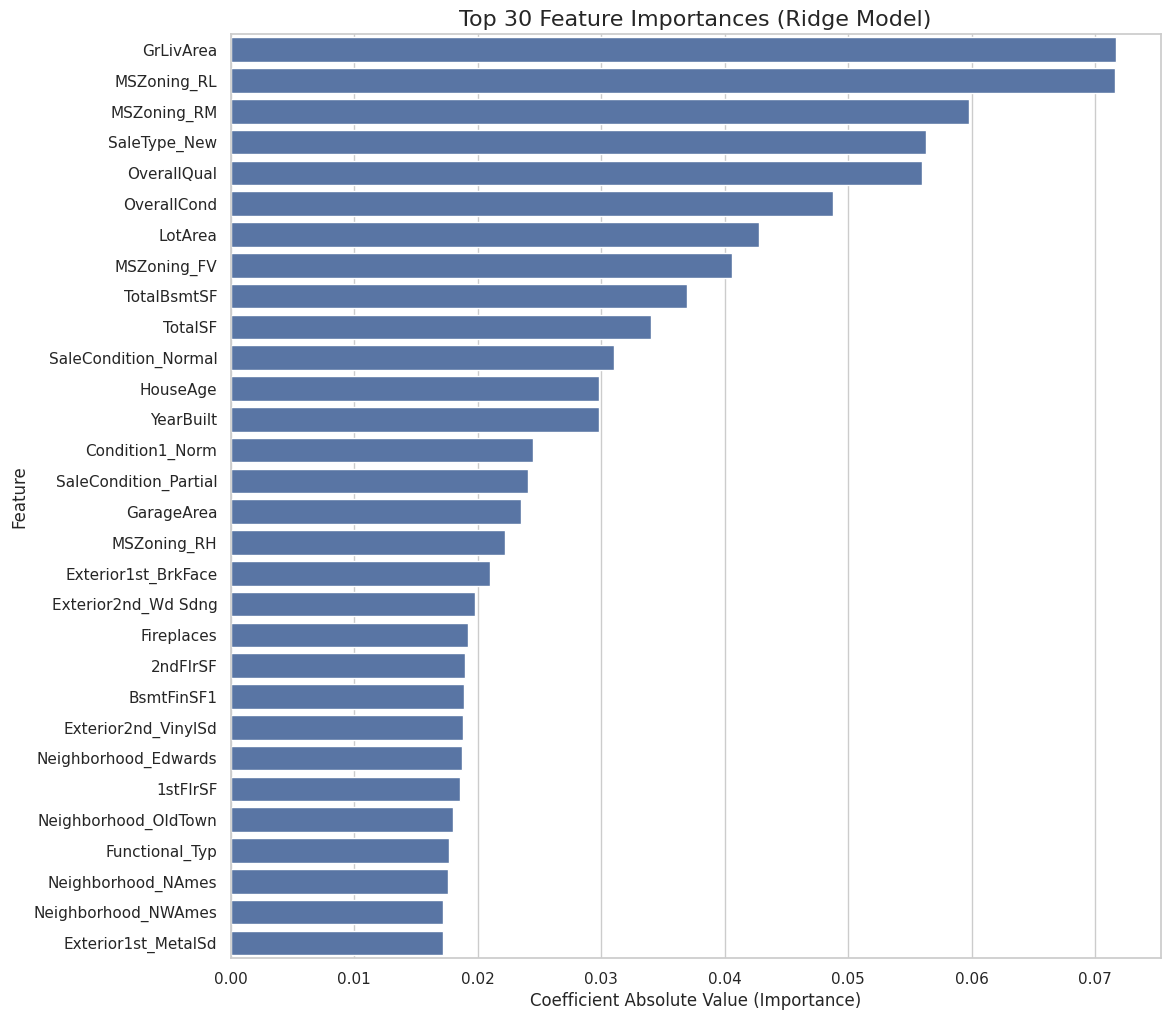

In [257]:
### extract coefficients from our best model (ridge_model)
coefficients = ridge_model.coef_

feature_names = X_train.columns

### create a DF for easy sorting and plotting
### We use np.abs() to get magnitude (importance)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values(by='importance', ascending=False)

### select top 30 features
top_30_features = feature_importance_df.head(30)

### create horizontal bar plot
plt.figure(figsize=(12, 12))
sns.barplot(
    x='importance',
    y='feature',
    data=top_30_features
)

### add plot titles
plt.title('Top 30 Feature Importances (Ridge Model)', fontsize=16)
plt.xlabel('Coefficient Absolute Value (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)

### display plot
plt.show()

### 4.9: Create Final Submission File

Now that we have a fully trained and scaled pipeline, we can use our best model (`ridge_model`) to make predictions on the processed test set (`df_test_scaled`). We will then reverse the log-transformation to get the final dollar amounts.

In [ ]:
### use our best model (the original ridge_model) to make predictions
final_predictions = ridge_model.predict(df_test_scaled)

### reverse the log transformation (np.expm1) to get back to dollar amounts
final_predictions_dollars = np.expm1(final_predictions)

### create the submission DataFrame
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': final_predictions_dollars
})

### save to a CSV file
submission.to_csv('submission.csv', index=False)

print("- Submission File Created -")
print("submission.csv created successfully.")
print(submission.head())

### 4.10: Discussion and Conclusions

This project successfully built a high-accuracy machine learning model to predict real estate prices using the Ames Housing Dataset. The project followed a rigorous, end-to-end workflow, moving from in-depth data analysis and cleaning to robust feature engineering and model comparison.

### 1. Data Cleaning and EDA

The intensive EDA and cleaning phase was a critical component of this project.

* **Precise Outlier Removal:** We identified and removed two anomalous outliers from `GrLivArea` and several from `GarageArea` to prevent them from skewing the model.
* **Missing Data:** All missing data across both train and test sets was systematically handled. This involved treating "fake" `NaN`s as categories (e.g., 'No Pool') and intelligently imputing "real" `NaN`s (`LotFrontage`) using the neighborhood median.
* **Feature Engineering & Transformation:** We engineered new features (like `TotalSF` and `HouseAge`) from the raw data *before* applying a `log1p` transformation to the complete set of skewed features. This ensured all features were mathematically sound and correctly normalized.
* **Encoding:** The dataset was made model-ready by ordinally mapping 17 ranked features and one-hot encoding all nominal features. This entire process was done on a combined train/test set to ensure identical feature creation and prevent data leakage.

### 2. Model Analysis and Results

The comprehensive data preparation had a profound impact on model performance. We compared four different supervised learning models on a 20% validation set.

| Model | Validation RMSE |
| :--- | :--- |
| **Ridge Regression** | **0.12181** |
| LGBM | 0.13315 |
| XGBoost | 0.13340 |
| RandomForest | 0.13943 |

* **Best Model:** The **Ridge Regression** model emerged as the decisive champion with a final validation RMSE of **0.12181**.
* **Key Insight:** This is the project's most significant finding. The robust data preparation created a dataset so clean and well-structured that a linear model decisively outperformed more complex, non-linear models. This proves that **intensive, high-quality feature engineering is more important than complex model selection.**

### 3. Confirmed Market Drivers: What Truly Sells a House?

The feature importance plot from our champion `Ridge` model provided a new, clear-cut set of insights:

1.  **Size is King:** `GrLivArea` (living area) is the **number one predictor** of house price.
2.  **Location & Type Matter:** `MSZoning_RL` (Residential Low Density) and `MSZoning_RM` (Medium Density) are the #2 and #3 most important features, confirming that zoning is a massive price driver.
3.  **New Construction:** `SaleType_New` is the #4 most important feature, providing a clear signal that being a "new" sale carries a massive price premium.
4.  **EDA Confirmed:** Our initial intuitions were correct. `OverallQual`, `OverallCond`, and `LotArea` all remain in the top 10 most important features.

### 4. Conclusion

This project demonstrates a complete, end-to-end machine learning workflow. We translated a raw, complex dataset into a high-precision predictive model.

The final `Ridge` model is not only highly accurate (0.122 RMSLE) but also highly interpretable. It provides a clear, actionable conclusion: a home's value in Ames is driven first by its **total size (GrLivArea)**, followed immediately by its **location, zoning, and "newness."**